In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [ ]:
tf_df = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/drive/MyDrive/training',
        shuffle=True,
        image_size = (IMAGE_SIZE,IMAGE_SIZE),
        batch_size = BATCH_SIZE
        )

Found 2188 files belonging to 3 classes.


In [ ]:
class_names = tf_df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
DF_LEN = len(tf_df)
DF_LEN

69

In [ ]:
for image_batch, label_batch in tf_df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(32, 256, 256, 3)
[0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 2 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1]


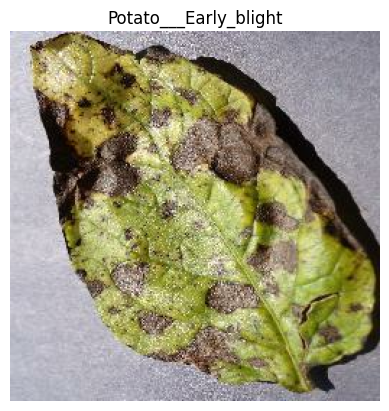

In [ ]:
for image_batch, label_batch in tf_df.take(1):
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis("off")

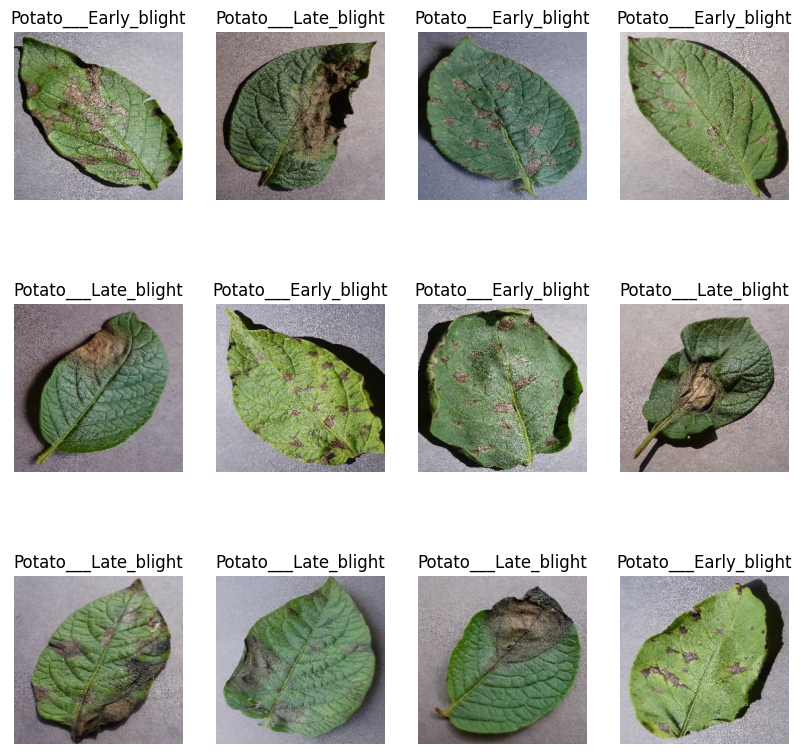

In [ ]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in tf_df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
# Train test split
# 80% for Training
# 10% for Validation
# 10% for Testing

In [ ]:
def get_partitions(df,train_split = 0.80,test_split = 0.10,val_split = 0.10,
                  shuffle = True,shuffle_size = 10000):

    df_len = len(df)

    if shuffle :
        df = df.shuffle(buffer_size = shuffle_size,seed = 41)

    train_size = int(df_len * train_split)
    val_size = int(df_len * val_split)

    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)

    return train_df,val_df,test_df


# lets say you have 10 images
# 5 goes for train_df
# 3 goes for val_df by skipping the first 5  and taking the next 3
# 2 goes for test_df by skipping the first 5 and skipping the next 3 and take the remaining

In [ ]:
train_df, val_df, test_df = get_partitions(tf_df)

In [ ]:
len(train_df), len(val_df),len(test_df)

(55, 6, 8)

In [ ]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.20)
])

In [ ]:
for image_batch, label_batch in tf_df.take(1):
    print(image_batch.shape)

# (32, 256, 256, 3)
# this will be the input shape that we will feed into the CNN

(32, 256, 256, 3)


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics = ['accuracy'])

In [ ]:
history = model.fit(train_df,epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose=1,
                    validation_data=val_df
               )

In [ ]:
score = model.evaluate(test_df)

8/8 [==============================] - 5s 32ms/step - loss: 0.0643 - accuracy: 0.9805


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 55}

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training vs Validation Loss')

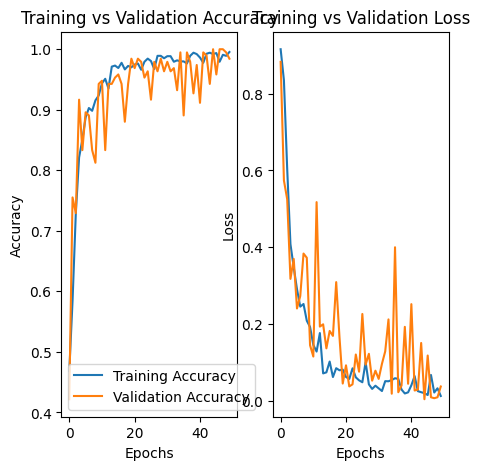

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'best')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 161ms/step
Predicted Label Potato___Late_blight


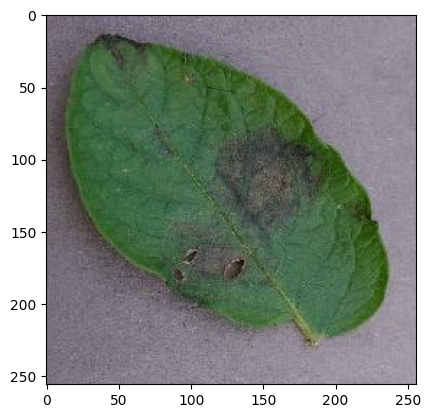

In [ ]:
for images_batch, labels_batch in test_df.take(1):
  image = image_batch[0].numpy().astype('uint8')
  label = label_batch[0].numpy().astype('uint8')

  print("Actual Label : ",class_names[labels_batch[0]])
  plt.imshow(image)

  batch_pred = model.predict(image_batch)
  print("Predicted Label",class_names[np.argmax(batch_pred[0])])

Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 42ms/step
Predicted Label Potato___Late_blight
Actual Label :  Potato___Late_blight
1/1 [==============================] - 0s 43ms/step
Predicted Label Potato___Late_blight
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 48ms/step
Predicted Label Potato___Early_blight
Actual Label :  Potato___healthy
1/1 [==============================] - 0s 35ms/step
Predicted Label Potato___healthy
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 47ms/step
Predicted Label Potato___Late_blight
Actual Label :  Potato___Late_blight
1/1 [==============================] - 0s 39ms/step
Predicted Label Potato___Early_blight
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 44ms/step
Predicted Label Potato___Early_blight
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 33ms/step
Predicted Label Potato___Earl

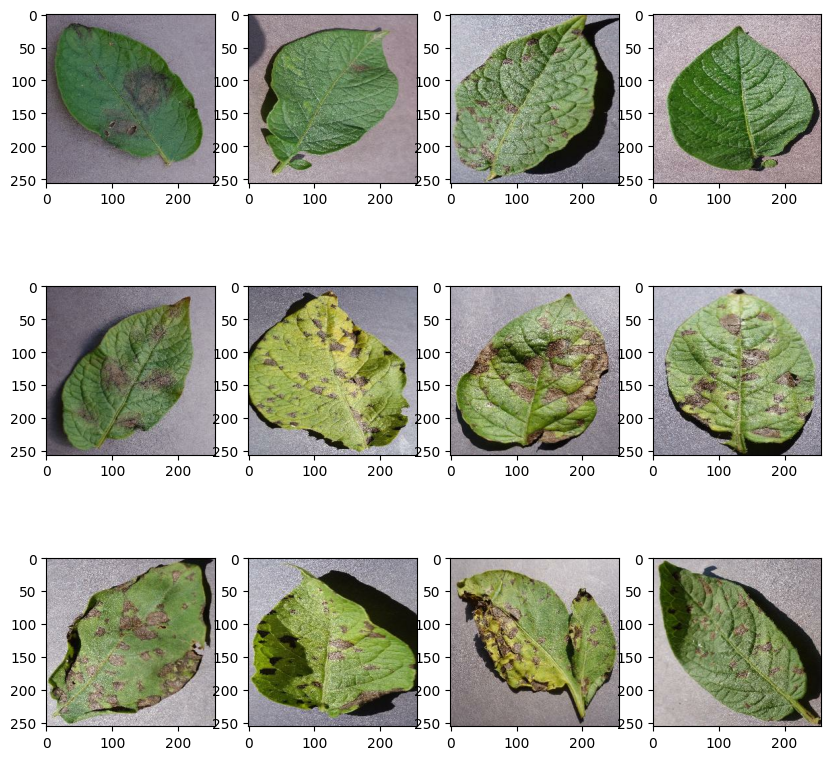

In [ ]:
plt.figure(figsize=(10,10))
for images_batch, labels_batch in test_df.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    image = image_batch[i].numpy().astype('uint8')
    label = label_batch[i].numpy().astype('uint8')

    print("Actual Label : ",class_names[labels_batch[i]])
    plt.imshow(image)

    batch_pred = model.predict(image_batch)
    print("Predicted Label",class_names[np.argmax(batch_pred[i])])

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  pred = model.predict(img_array)

  predicted_class = class_names[np.argmax(pred[0])]
  confidence = round(100 * (np.max(pred[0])), 2)
  return predicted_class, confidence


1/1 [==============================] - 0s 25ms/step


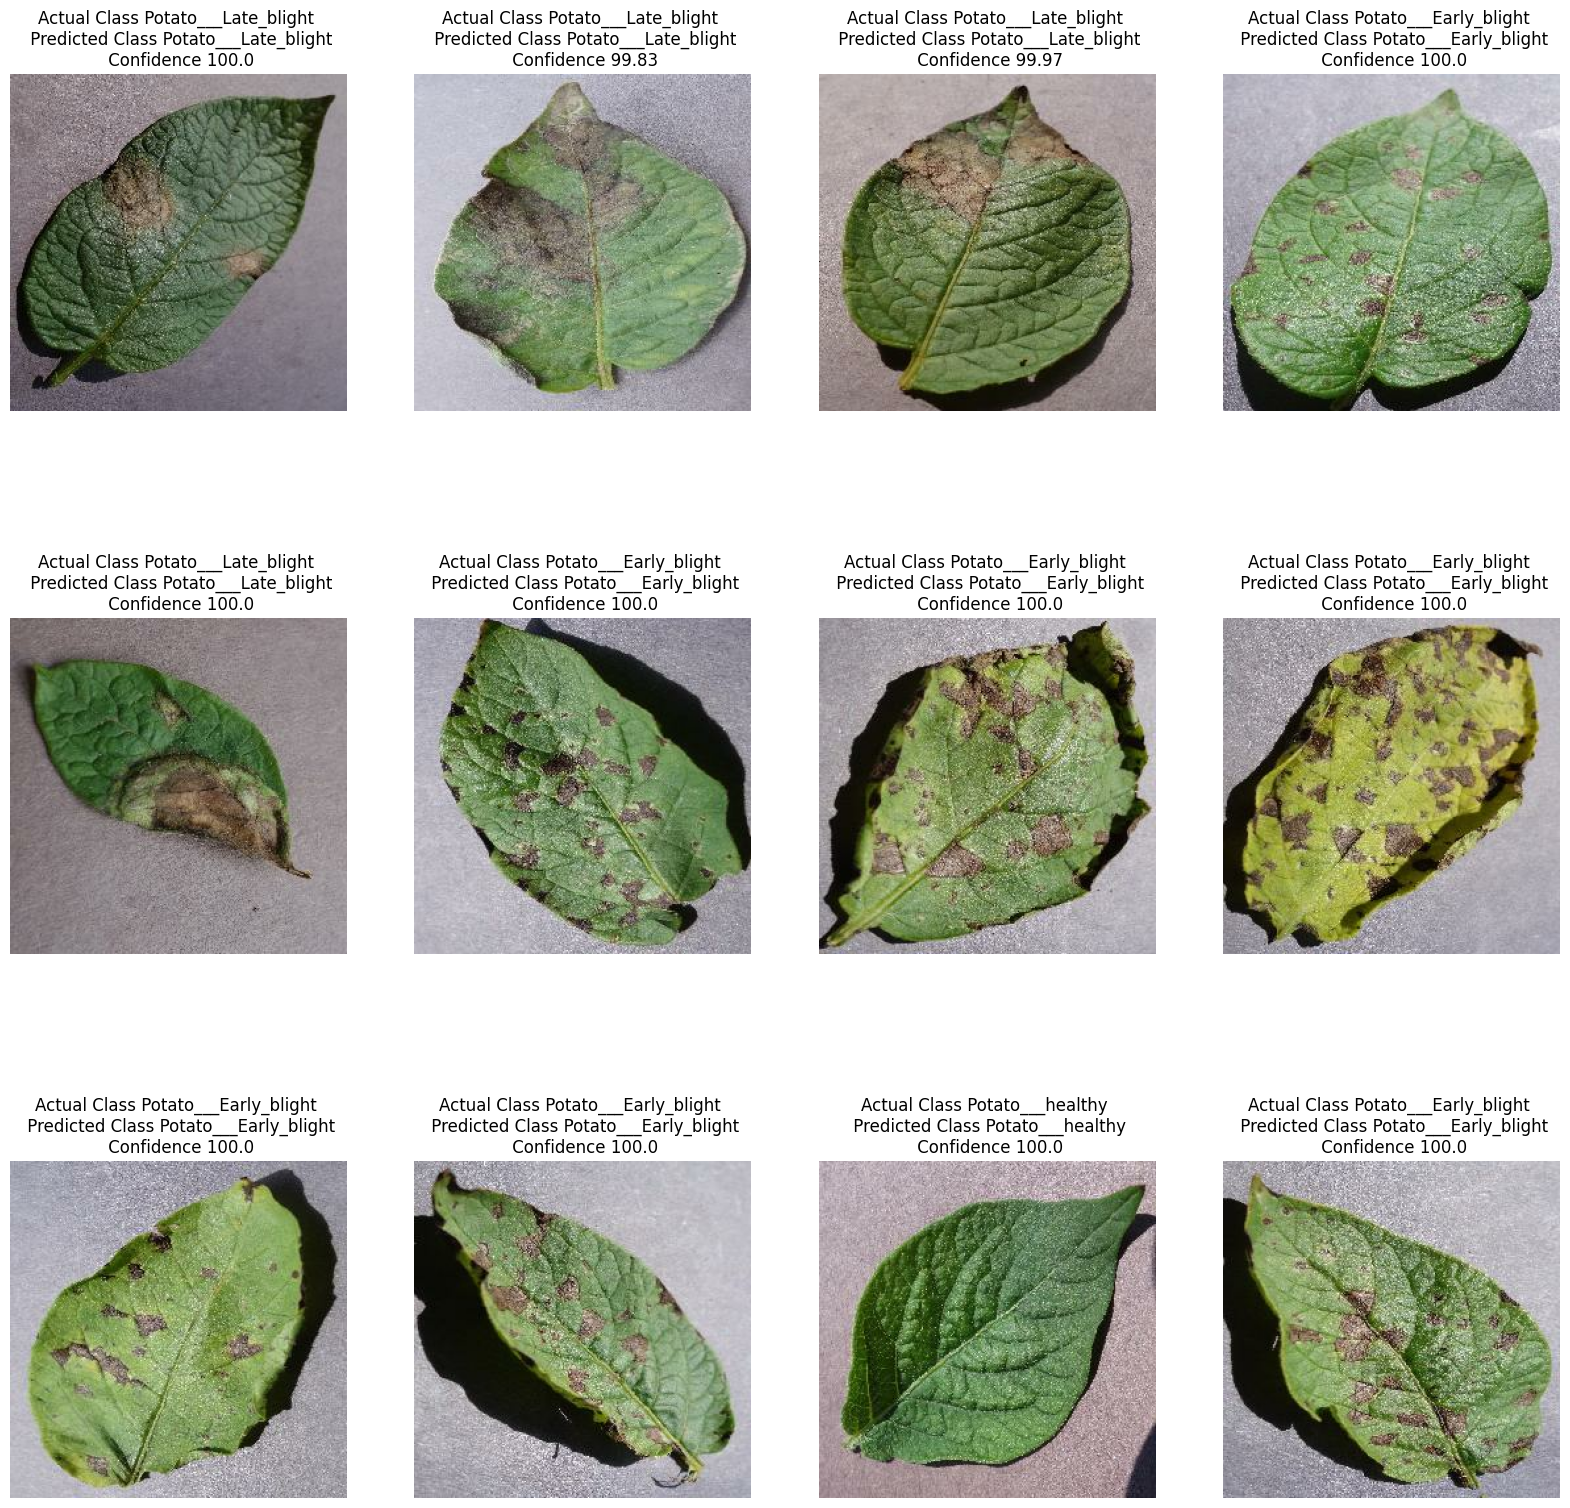

In [ ]:
plt.figure(figsize=(20,20))
for images, labels in test_df.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    pred_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual Class {actual_class} \n Predicted Class {pred_class}\n Confidence {confidence}")

    plt.axis('off')


In [ ]:
mkdir models

In [ ]:
model_version = 2
model.save(f'../models/{model_version}')

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("../models")])+1
model.save(f"../models/{model_version}")

In [ ]:
os.listdir('../models')

['3', '2']

In [ ]:
!cp /content/model.h5 /content/drive/MyDrive/Models/model.h5


In [ ]:
model.save("potato_CNN.h5")

In [ ]:
! cp /content/potato_CNN.h5 /content/drive/MyDrive/Potato_Classification_models